In [338]:
# Import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score

In [339]:
# load MNIST dataset
from keras.datasets import mnist

# Load dataset into Train and Test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Check dimensions of sets
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

4


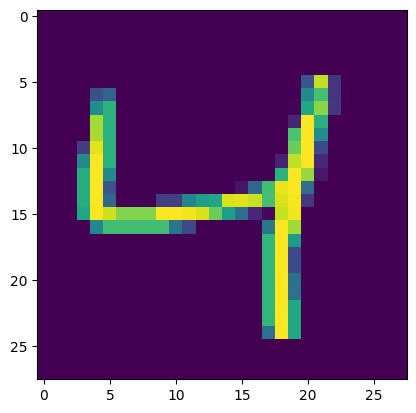

In [340]:
# view an image and print its corresponding label
img_index = 2
plt.imshow(X_train[img_index,:,:])
print(y_train[img_index])

5 0 4 1 9 
2 1 3 1 4 
3 5 3 6 1 
7 2 8 6 9 
4 0 9 1 1 


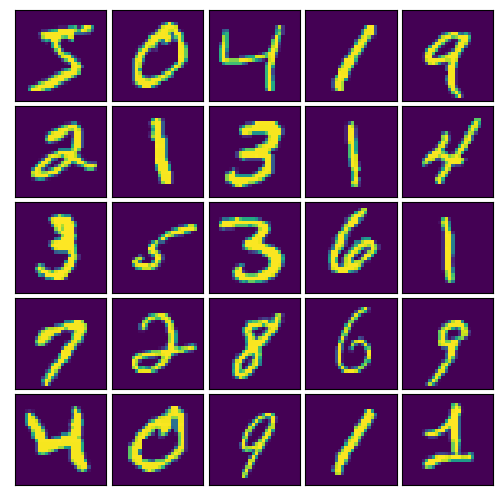

In [341]:
# view a set of images (and corresponding labels) to get more of a sense of the dataset
fig, ax = plt.subplots(5, 5)
img_index = 0
for i in range(5):
    labels = ""
    for j in range(5):
        ax[i,j].imshow(X_train[img_index, :, :])
        labels += f'{y_train[img_index]} '
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        img_index += 1
    print(labels)
plt.tight_layout(pad=0, w_pad=-10)


In [342]:
# Random Forest model requires 2 dimensional array rather than three

# ... so reshape X_train
image_index, image_x_dimension, image_y_dimension = X_train.shape
X_train = X_train.reshape(image_index, image_x_dimension * image_y_dimension)

# ... and reshape X_test
image_index, image_x_dimension, image_y_dimension = X_test.shape
X_test = X_test.reshape(image_index, image_x_dimension * image_y_dimension)

# Check new dimensions of sets
X_train.shape, X_test.shape

((60000, 784), (10000, 784))

In [343]:
# Split Dev set from Train set
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Final check of dimensions of sets
X_train.shape, y_train.shape, X_dev.shape, y_dev.shape, X_test.shape, y_test.shape

((48000, 784), (48000,), (12000, 784), (12000,), (10000, 784), (10000,))


We train our machine learning model on the 'Train'ing data, then use the 'Dev'elopment data for the development cycle of testing and refining our model, where we are looking to minimise overfitting or underfitting etc. 'Test'ing data is held back to test a release candidate, to see how well it works on novel data. The degree to which it is successful on the test set, is the degree to which it will be able to make useful future predictions, which after all is what this is all about.


In [344]:
# Create a classification model, and get its parameters
clf = RandomForestClassifier()
clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Let's tune max_depth, which sets how many levels the decision trees can have. We can see by default it is unlimited, which will lead to overfitting, as the tree will keep branching until every leaf holds a single datapoint. Overfitting is where the model performs brilliantly on the Train set, but badly on the Test set since it is fitted too closely, too precisely, to the Training data.  max_depth will be the parameter that has the greatest overall effect on the quality of the model.

In [345]:
# Build models with max_depth from 2 up to 10, storing the results each time

scores_against_Train_set = []
scores_against_Dev_set = []
max_Depths_tested = []
r = 4

print('Max_depths completed: ', end=' ')
for max_depth in range(2,11):

    demo = RandomForestClassifier(max_depth=max_depth, random_state=r)
    demo.fit(X_train, y_train)
    score_against_Train_set = demo.score(X_train, y_train)
    score_against_Dev_set = demo.score(X_dev, y_dev)

    scores_against_Train_set.append(score_against_Train_set)
    scores_against_Dev_set.append(score_against_Dev_set)
    max_Depths_tested.append(max_depth)

    print(max_depth, end=' ')


Max_depths completed:  2 3 4 5 6 7 8 9 10 

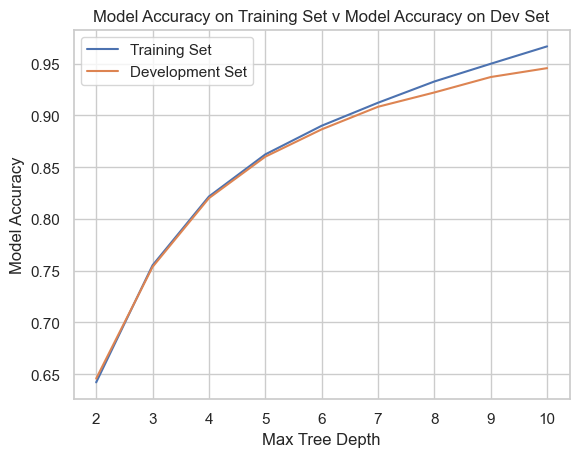

In [346]:
# Plot the results against each other
sns.set(style="whitegrid")
fig, ax = plt.subplots()
plt.plot(max_Depths_tested, scores_against_Train_set, label='Training Set')
plt.plot(max_Depths_tested, scores_against_Dev_set, label='Development Set')
plt.title('Model Accuracy on Training Set v Model Accuracy on Dev Set')
plt.xlabel('Max Tree Depth')
plt.ylabel('Model Accuracy')
ax.legend();

Above a max_depth of 7, the accuracy on the Dev set increasingly falls away, so lets use a max_depth of 7 for the final model.

In [348]:
# train the final Random Forest model, and fit it to the Training data
clf = RandomForestClassifier(max_depth=7, random_state=r)
clf.fit(X_train, y_train)

# make predictions on the Test data
y_pred = clf.predict(X_test).reshape(-1,1)

In [349]:
# Display a confusion matrix for the model on the Test set

classes = ['Zero', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Nine']
conf_matrix = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(conf_matrix, columns=classes, index=classes)
cm_df

,Zero,One,Two,Three,Four,Five,Six,Seven,Eight,Nine
Zero,964,1,1,1,0,1,5,2,4,1
One,0,1116,3,2,0,1,5,1,7,0
Two,7,7,937,14,14,0,14,19,14,6
Three,7,3,25,915,1,12,4,17,14,12
Four,2,4,2,0,851,0,21,2,13,87
Five,11,13,4,47,14,745,18,8,15,17
Six,16,4,4,1,11,9,906,1,6,0
Seven,2,15,32,4,5,0,0,922,3,45
Eight,3,10,7,22,7,14,16,6,860,29
Nine,6,7,2,12,27,3,4,14,16,918


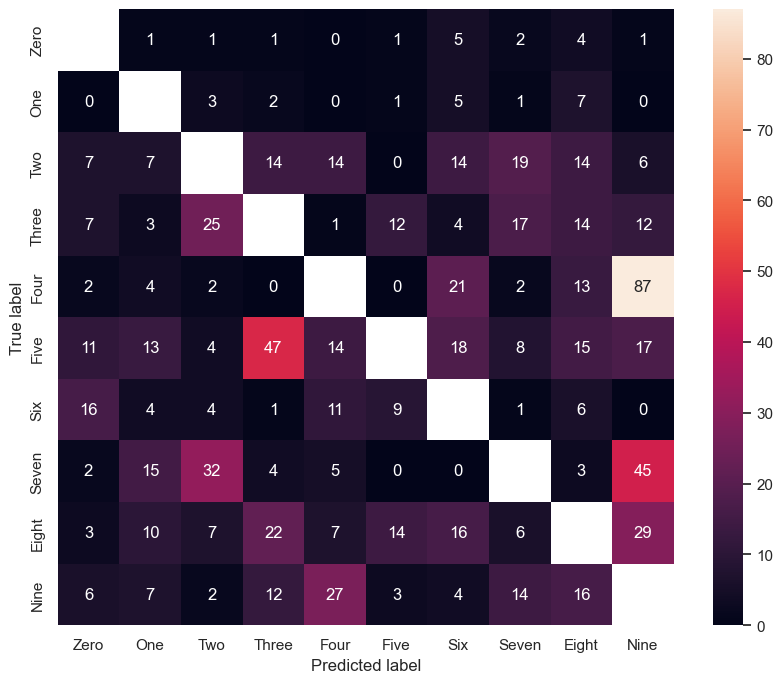

In [350]:
# The incorrect predictions counted in the confusion matrix might be better visualised as a heatmap

temp = cm_df.copy()                         
for i in range(len(temp)):
    temp.iat[i,i] = np.NaN

plt.figure(figsize=(10,8))
sns.heatmap(temp, annot=True, square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label');

The confusion matrix tells us how many times each number was mistaken for each alternative.
But to know which number was misidentified most often in total, lets sum the misidentifications

In [351]:
conf_sums = temp.sum(axis=1).astype(int)    # sum each row
conf_sums.sort_values(ascending=False)      # sort the results

Five     147
Four     131
Eight    114
Seven    106
Two       95
Three     95
Nine      91
Six       52
One       19
Zero      16
dtype: int32

In [356]:
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
F1 = 2 * (prec * rec) / (prec + rec)

print("Accuracy:\t", clf.score(X_test, y_test))
print('Precision:\t', prec)
print('Recall:\t\t', rec)
print('F1 score:\t', F1)

Accuracy:	 0.9134
Precision:	 0.9145344794087515
Recall:		 0.9134
F1 score:	 0.9139668876557812
